In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import imageio

In [12]:
import pandas as pd
import os

In [30]:
ship_dir = "/mnt/deep_learning"
augmented_dir = "/mnt/deep_learning_v2"
train_image_dir = os.path.join(ship_dir, 'train_v2')
augmented_image_dir = os.path.join(augmented_dir, 'augmented')
from skimage.morphology import label

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import imageio
import pandas as pd
import os
from keras_preprocessing.image.iterator import Iterator
from keras_preprocessing import image
from tensorflow.python.keras import backend
from tensorflow.python.util import tf_inspect
import warnings
from keras_preprocessing.image.utils import array_to_img

class NumpyArrayIterator(image.NumpyArrayIterator):
    def __init__(self,
                 x,
                 y,
                 image_data_generator,
                 batch_size=32,
                 shuffle=False,
                 sample_weight=None,
                 seed=None,
                 data_format='channels_last',
                 save_to_dir=None,
                 save_prefix='',
                 save_format='png',
                 subset=None,
                 dtype='float32'):
        super(NumpyArrayIterator, self).__init__(x,
                 y,
                 image_data_generator,
                 batch_size=batch_size,
                 shuffle=shuffle,
                 sample_weight=sample_weight,
                 seed=seed,
                 data_format=data_format,
                 save_to_dir=save_to_dir,
                 save_prefix=save_prefix,
                 save_format=save_format,
                 subset=subset,
                 dtype=dtype)

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros(tuple([len(index_array)] + list(self.x.shape)[1:]),
                           dtype=self.dtype)
        for i, j in enumerate(index_array):
            x = self.x[j]
            params = self.image_data_generator.get_random_transform(x.shape)
            x = self.image_data_generator.apply_transform(
                x.astype(self.dtype), params)
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x

        if self.save_to_dir:
            for i, j in enumerate(index_array):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}.{format}'.format(
                    prefix=self.save_prefix,
                    format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
        batch_x_miscs = [xx[index_array] for xx in self.x_misc]
        output = (batch_x if batch_x_miscs == []
                  else [batch_x] + batch_x_miscs,)
        if self.y is None:
            return output[0]
        output += (self.y[index_array],)
        if self.sample_weight is not None:
            output += (self.sample_weight[index_array],)
        return output



class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self,
               featurewise_center=False,
               samplewise_center=False,
               featurewise_std_normalization=False,
               samplewise_std_normalization=False,
               zca_whitening=False,
               zca_epsilon=1e-6,
               rotation_range=0,
               width_shift_range=0.,
               height_shift_range=0.,
               brightness_range=None,
               shear_range=0.,
               zoom_range=0.,
               channel_shift_range=0.,
               fill_mode='nearest',
               cval=0.,
               horizontal_flip=False,
               vertical_flip=False,
               rescale=None,
               preprocessing_function=None,
               data_format=None,
               validation_split=0.0,
               interpolation_order=1,
               dtype=None):

        self.featurewise_center = featurewise_center
        self.samplewise_center = samplewise_center
        self.featurewise_std_normalization = featurewise_std_normalization
        self.samplewise_std_normalization = samplewise_std_normalization
        self.zca_whitening = zca_whitening
        self.zca_epsilon = zca_epsilon
        self.rotation_range = rotation_range
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range
        self.shear_range = shear_range
        self.zoom_range = zoom_range
        self.channel_shift_range = channel_shift_range
        self.fill_mode = fill_mode
        self.cval = cval
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.rescale = rescale
        self.preprocessing_function = preprocessing_function
        self.dtype = dtype
        self.interpolation_order = interpolation_order

        if data_format is None:
            data_format = backend.image_data_format()
        kwargs = {}
        if 'dtype' in tf_inspect.getfullargspec(
                image.ImageDataGenerator.__init__)[0]:
            if dtype is None:
                dtype = backend.floatx()
            kwargs['dtype'] = dtype


        if data_format not in {'channels_last', 'channels_first'}:
            raise ValueError(
                '`data_format` should be `"channels_last"` '
                '(channel after row and column) or '
                '`"channels_first"` (channel before row and column). '
                'Received: %s' % data_format)
        self.data_format = data_format
        if data_format == 'channels_first':
            self.channel_axis = 1
            self.row_axis = 2
            self.col_axis = 3
        if data_format == 'channels_last':
            self.channel_axis = 3
            self.row_axis = 1
            self.col_axis = 2
        if validation_split and not 0 < validation_split < 1:
            raise ValueError(
                '`validation_split` must be strictly between 0 and 1. '
                ' Received: %s' % validation_split)
        self._validation_split = validation_split

        self.mean = None
        self.std = None
        self.principal_components = None

        if np.isscalar(zoom_range):
            self.zoom_range = [1 - zoom_range, 1 + zoom_range]
        elif len(zoom_range) == 2:
            self.zoom_range = [zoom_range[0], zoom_range[1]]
        else:
            raise ValueError('`zoom_range` should be a float or '
                             'a tuple or list of two floats. '
                             'Received: %s' % (zoom_range,))
        if zca_whitening:
            if not featurewise_center:
                self.featurewise_center = True
                warnings.warn('This ImageDataGenerator specifies '
                              '`zca_whitening`, which overrides '
                              'setting of `featurewise_center`.')
            if featurewise_std_normalization:
                self.featurewise_std_normalization = False
                warnings.warn('This ImageDataGenerator specifies '
                              '`zca_whitening` '
                              'which overrides setting of'
                              '`featurewise_std_normalization`.')
        if featurewise_std_normalization:
            if not featurewise_center:
                self.featurewise_center = True
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_std_normalization`, '
                              'which overrides setting of '
                              '`featurewise_center`.')
        if samplewise_std_normalization:
            if not samplewise_center:
                self.samplewise_center = True
                warnings.warn('This ImageDataGenerator specifies '
                              '`samplewise_std_normalization`, '
                              'which overrides setting of '
                              '`samplewise_center`.')
        if brightness_range is not None:
            if (not isinstance(brightness_range, (tuple, list)) or
                    len(brightness_range) != 2):
                raise ValueError(
                    '`brightness_range should be tuple or list of two floats. '
                    'Received: %s' % (brightness_range,))
        self.brightness_range = brightness_range

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        return NumpyArrayIterator(
            x,
            y,
            self,
            batch_size=batch_size,
            shuffle=shuffle,
            sample_weight=sample_weight,
            seed=seed,
            data_format=self.data_format,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format,
            subset=subset
        )

In [32]:
from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)


In [33]:
masks = pd.read_csv(os.path.join(ship_dir,
                                 'train_ship_segmentations_v2.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
print(masks.head())

231723 masks found
192556
         ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [34]:
images_with_ship = masks.ImageId[masks.EncodedPixels.isnull()==False]
images_with_ship = np.unique(images_with_ship.values)

In [35]:
dg_args = dict(featurewise_center = False,
                  samplewise_center = False,
                  rotation_range = 25,
                  width_shift_range = 0.1,
                  height_shift_range = 0.1,
#                   shear_range = 0.01,
#                   zoom_range = [0.9, 1.25],
                  horizontal_flip = True,
                  vertical_flip = True,
                  fill_mode = 'reflect',
                  data_format = 'channels_last')

dg_args_label = dict(featurewise_center = False,
                  samplewise_center = False,
                  rotation_range = 25,
                  width_shift_range = 0.1,
                  height_shift_range = 0.1,
#                   shear_range = 0.01,
#                   zoom_range = [0.9, 1.25],
                  horizontal_flip = True,
                  vertical_flip = True,
                  fill_mode = 'constant',
                  cval = 0,
                  data_format = 'channels_last')

image_gen = CustomImageDataGenerator(**dg_args)
label_gen = CustomImageDataGenerator(**dg_args_label)

['229084 4 229852 6 230619 10 231387 12 232155 15 232172 1 232922 21 233690 24 234457 27 235225 30 235993 32 236760 35 237528 34 238295 35 239063 35 239831 34 240599 34 241367 33 242135 33 242902 34 243670 33 244437 34 245205 33 245973 33 246740 34 247508 33 248275 34 249043 34 249811 34 250578 35 251346 34 252113 35 252881 34 253649 34 254416 35 255184 34 255951 35 256719 34 257487 34 258254 35 259022 34 259789 35 260557 34 261325 34 262092 35 262860 34 263627 35 264395 34 265164 33 265931 34 266699 33 267466 34 268234 33 269002 33 269769 34 270537 33 271304 34 272072 33 272840 33 273607 35 274375 34 275142 35 275910 35 276678 34 277445 35 278213 34 278980 35 279748 35 280516 34 281283 35 282051 34 282818 35 283586 35 284354 34 285121 35 285889 34 286656 35 287424 35 288192 34 288959 35 289728 33 290496 33 291263 34 292031 33 292798 34 293566 33 294334 33 295101 34 295869 33 296636 34 297404 33 298172 34 298939 35 299707 34 300474 35 301242 34 302011 33 302781 31 303554 25 304325 22 3

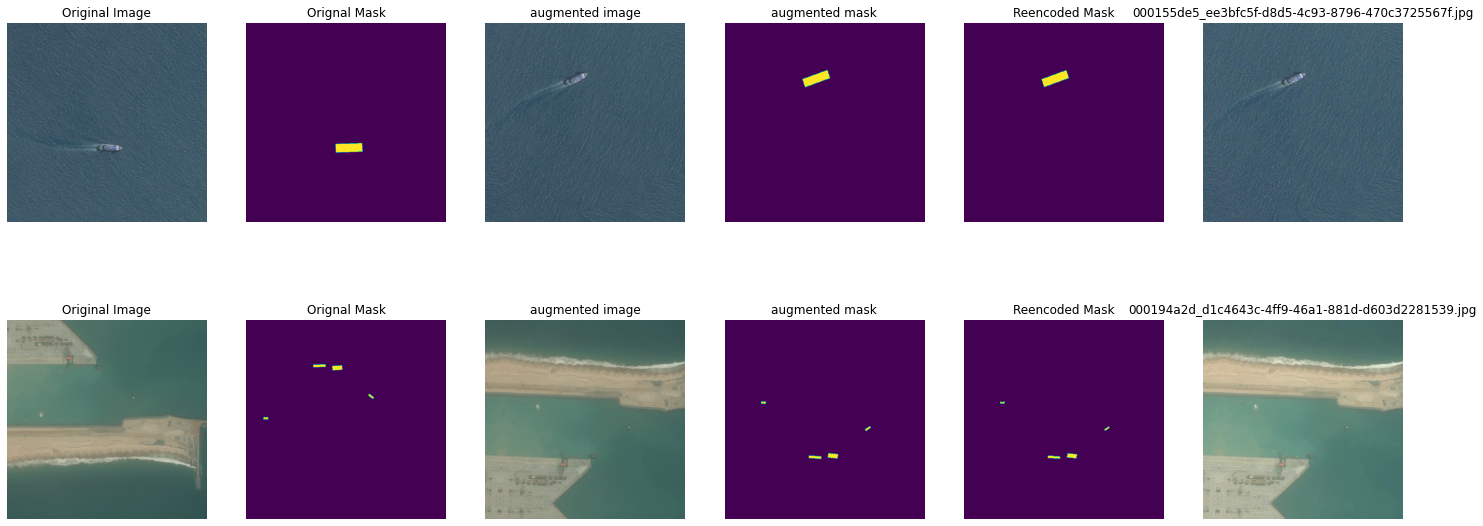

In [39]:
from skimage.io import imread
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
import uuid

aug_image_size = 2
fig, m_axs = plt.subplots(aug_image_size, 6, figsize = (25, 5*aug_image_size))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2, ax3, ax4, ax5, ax6), c_img_name in zip(m_axs, images_with_ship[:aug_image_size]):
    orig_img = plt.imread(os.path.join(train_image_dir, c_img_name))
    ax1.imshow(orig_img)
    ax1.set_title('Original Image')
    
    rgb_path = os.path.join(train_image_dir, c_img_name)
    c_img = imread(rgb_path)
    q = 'ImageId=="{}"'.format(c_img_name)
    rle_0 = masks.query(q)['EncodedPixels'] # an efficient way to filter against pandas dataframe
    c_mask = masks_as_image(rle_0)
    ax2.imshow(c_mask[:, :, 0])
    ax2.set_title("Orignal Mask")
    seed = np.random.choice(range(999999))
    r = str(uuid.uuid4())
    aug_prefix = "{}_{}".format(c_img_name.split(".")[0], r)
    g_x = image_gen.flow(np.expand_dims(orig_img, axis=0), batch_size = 1, seed = seed, 
                         save_to_dir=augmented_image_dir, 
                         save_prefix=aug_prefix, 
                         save_format="jpg")
    g_y = label_gen.flow(np.expand_dims(c_mask, axis=0), batch_size = 1, seed = seed)
    
    aug_x = g_x.next()
    aug_x_1 = np.squeeze(aug_x, axis=0).astype(int)
    aug_y = g_y.next()
    aug_y_1 = np.squeeze(aug_y, axis=0)

    ax3.imshow(aug_x_1)
    ax3.set_title("augmented image")
    
    ax4.imshow(aug_y_1[:,:,0])
    ax4.set_title("augmented mask")
    
    rle_1 = multi_rle_encode(aug_y_1)
    c_mask_1 = masks_as_image(rle_1)
    
    ax5.imshow(c_mask_1[:, :, 0])
    ax5.set_title("Reencoded Mask")
    retrieved_aug_jpg = plt.imread(os.path.join(augmented_image_dir, "{}.jpg".format(aug_prefix)))
    ax6.imshow(retrieved_aug_jpg)
    ax6.set_title("{}.jpg".format(aug_prefix))
    

In [44]:
rle_1

['107070 8 107838 8 108606 8 109374 8 110144 6 110912 6 111680 6 112448 6 113216 6 113984 6 114752 6 115520 6 116286 8 117054 8 117822 8 118590 8 119358 8',
 '414376 3 415144 6 415911 7 416678 7 417445 8 418213 7 418980 8 419747 8 420515 7 421283 8 422050 8 422817 8 423585 7 424352 7 425119 8 425886 8 426654 7 427422 6 428191 5 428961 2',
 '303888 5 304653 8 305413 16 306181 16 306949 16 307717 16 308485 16 309253 16 310021 16 310789 16 311557 17 312326 16 313094 16 313862 16 314630 16 315398 16 316166 16 316934 16 317702 16 318470 16 319238 16 320006 16 320775 16 321543 16 322311 16 323079 16 323847 16 324615 16 325383 17 326152 16 326920 16 327688 16 328456 16 329224 16 329992 16 330760 16 331528 16 332296 9 333064 7',
 '247823 8 248590 9 249358 9 250126 9 250894 9 251662 9 252430 9 253198 9 253966 9 254734 9 255502 9 256270 9 257038 9 257806 9 258574 9 259342 9 260110 9 260878 9 261647 9 262415 9 263183 9 263951 9 264719 9 265488 8 266256 9 267024 9 267792 9 268560 9 269328 9 270096

In [54]:
aug_test_csv = "train_ship_segmentations_v2_aug_test.csv"
with open("{}/{}".format(augmented_dir, aug_test_csv), "a") as f:
    for rle in rle_1:
        f.write("{},{}\n".format("000194a2d_d1c4643c-4ff9-46a1-881d-d603d2281539.jpg", rle))

In [55]:
augmented_test_dir = "/mnt/deep_learning_v2"
augmented_test_image_dir = os.path.join(augmented_dir, 'augmented_test')
aug_masks = pd.read_csv(os.path.join(augmented_test_dir,
                                 aug_test_csv))
print(aug_masks.shape[0], 'masks found')
print(aug_masks['ImageId'].value_counts().shape[0])
print(aug_masks.head())

12 masks found
1
                                             ImageId  \
0  000194a2d_d1c4643c-4ff9-46a1-881d-d603d2281539...   
1  000194a2d_d1c4643c-4ff9-46a1-881d-d603d2281539...   
2  000194a2d_d1c4643c-4ff9-46a1-881d-d603d2281539...   
3  000194a2d_d1c4643c-4ff9-46a1-881d-d603d2281539...   
4  000194a2d_d1c4643c-4ff9-46a1-881d-d603d2281539...   

                                       EncodedPixels  
0  107070 8 107838 8 108606 8 109374 8 110144 6 1...  
1  414376 3 415144 6 415911 7 416678 7 417445 8 4...  
2  303888 5 304653 8 305413 16 306181 16 306949 1...  
3  247823 8 248590 9 249358 9 250126 9 250894 9 2...  
4  362934 2 363700 4 364467 7 365233 8 366000 8 3...  


In [56]:
aug_images_with_ship = aug_masks.ImageId[aug_masks.EncodedPixels.isnull()==False]
aug_images_with_ship = np.unique(aug_images_with_ship.values)

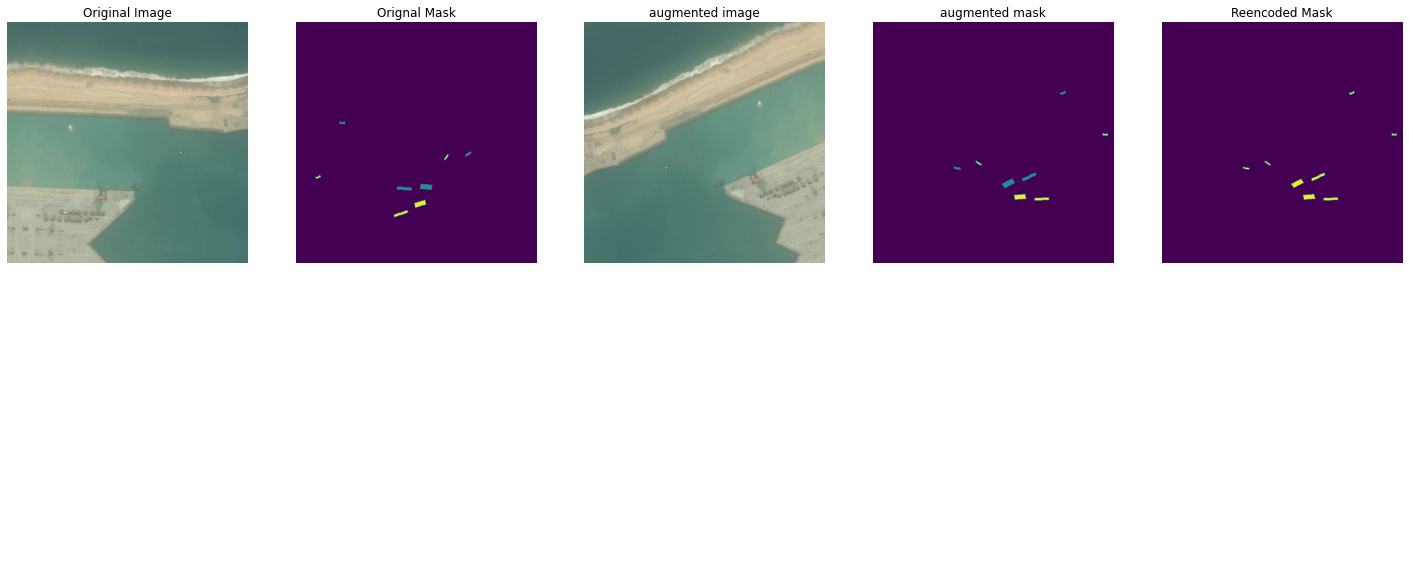

In [59]:
aug_image_size = 2
fig, m_axs = plt.subplots(aug_image_size, 5, figsize = (25, 5*aug_image_size))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2, ax3, ax4, ax5), c_img_name in zip(m_axs, aug_images_with_ship[:aug_image_size]):
    orig_img = plt.imread(os.path.join(augmented_test_image_dir, c_img_name))
    ax1.imshow(orig_img)
    ax1.set_title('Original Image')
    
    rgb_path = os.path.join(augmented_test_image_dir, c_img_name)
    c_img = imread(rgb_path)
    q = 'ImageId=="{}"'.format(c_img_name)
    rle_0 = aug_masks.query(q)['EncodedPixels'] # an efficient way to filter against pandas dataframe
    c_mask = masks_as_image(rle_0)
    ax2.imshow(c_mask[:, :, 0])
    ax2.set_title("Orignal Mask")
    seed = np.random.choice(range(999999))
    r = str(uuid.uuid4())
    aug_prefix = "{}_{}".format(c_img_name.split(".")[0], r)
    g_x = image_gen.flow(np.expand_dims(orig_img, axis=0), batch_size = 1, seed = seed)
#                          save_to_dir=augmented_image_dir, 
#                          save_prefix=aug_prefix, 
#                          save_format="jpg")
    g_y = label_gen.flow(np.expand_dims(c_mask, axis=0), batch_size = 1, seed = seed)
    
    aug_x = g_x.next()
    aug_x_1 = np.squeeze(aug_x, axis=0).astype(int)
    aug_y = g_y.next()
    aug_y_1 = np.squeeze(aug_y, axis=0)

    ax3.imshow(aug_x_1)
    ax3.set_title("augmented image")
    
    ax4.imshow(aug_y_1[:,:,0])
    ax4.set_title("augmented mask")
    
    rle_1 = multi_rle_encode(aug_y_1)
    c_mask_1 = masks_as_image(rle_1)
    
    ax5.imshow(c_mask_1[:, :, 0])
    ax5.set_title("Reencoded Mask")
#     retrieved_aug_jpg = plt.imread(os.path.join(augmented_image_dir, "{}.jpg".format(aug_prefix)))
#     ax6.imshow(retrieved_aug_jpg)
#     ax6.set_title("{}.jpg".format(aug_prefix))

In [66]:
import sys
oldStdout = sys.stdout
file = open('/mnt/deep_learning_v2/logs/augmentation.out', 'w')
sys.stdout = file

In [ ]:
aug_csv = "train_ship_segmentations_v2_aug.csv"
for i in range(50):
    print("iteration: {}".format(i), flush=True)
    for c_img_name in images_with_ship:
        orig_img = plt.imread(os.path.join(train_image_dir, c_img_name))
        rgb_path = os.path.join(train_image_dir, c_img_name)
        c_img = imread(rgb_path)
        q = 'ImageId=="{}"'.format(c_img_name)
        rle_0 = masks.query(q)['EncodedPixels'] # an efficient way to filter against pandas dataframe
        c_mask = masks_as_image(rle_0)
        seed = np.random.choice(range(999999))
        r = str(uuid.uuid4())
        aug_prefix = "{}_{}".format(c_img_name.split(".")[0], r)
        g_x = image_gen.flow(np.expand_dims(orig_img, axis=0), batch_size = 1, seed = seed, 
                             save_to_dir=augmented_image_dir, 
                             save_prefix=aug_prefix, 
                             save_format="jpg")
        g_y = label_gen.flow(np.expand_dims(c_mask, axis=0), batch_size = 1, seed = seed)

        aug_x = g_x.next()
        aug_y = g_y.next()
        aug_y_1 = np.squeeze(aug_y, axis=0)
        rle_1 = multi_rle_encode(aug_y_1)
        with open("{}/{}".format(augmented_dir, aug_csv), "a") as f:
            for rle in rle_1:
                f.write("{},{}\n".format("{}.jpg".format(aug_prefix), rle))

In [ ]:
sys.stdout = oldStdout